In [25]:
import pandas as pd
import numpy as np
from ctgan import CTGAN
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

In [26]:
data_ohe = pd.read_csv("data/processed/mushroom_processed3000.csv")
discrete_features_ohe = ['habitat',
 'class_e',
 'class_p',
 'cap-shape_b',
 'cap-shape_c',
 'cap-shape_f',
 'cap-shape_k',
 'cap-shape_s',
 'cap-shape_x',
 'cap-surface_f',
 'cap-surface_g',
 'cap-surface_s',
 'cap-surface_y',
 'cap-color_b',
 'cap-color_c',
 'cap-color_e',
 'cap-color_g',
 'cap-color_n',
 'cap-color_p',
 'cap-color_r',
 'cap-color_u',
 'cap-color_w',
 'cap-color_y',
 'ruises_f',
 'ruises_t',
 'odor_a',
 'odor_c',
 'odor_f',
 'odor_l',
 'odor_m',
 'odor_n',
 'odor_p',
 'odor_s',
 'odor_y',
 'gill-attachment_a',
 'gill-attachment_f',
 'gill-spacing_c',
 'gill-spacing_w',
 'gill-size_b',
 'gill-size_n',
 'gill-color_b',
 'gill-color_e',
 'gill-color_g',
 'gill-color_h',
 'gill-color_k',
 'gill-color_n',
 'gill-color_o',
 'gill-color_p',
 'gill-color_r',
 'gill-color_u',
 'gill-color_w',
 'gill-color_y',
 'stalk-shape_e',
 'stalk-shape_t',
 'stalk-root_b',
 'stalk-root_c',
 'stalk-root_e',
 'stalk-root_r',
 'stalk-surface-above-ring_f',
 'stalk-surface-above-ring_k',
 'stalk-surface-above-ring_s',
 'stalk-surface-above-ring_y',
 'stalk-surface-below-ring_f',
 'stalk-surface-below-ring_k',
 'stalk-surface-below-ring_s',
 'stalk-surface-below-ring_y',
 'stalk-color-above-ring_b',
 'stalk-color-above-ring_c',
 'stalk-color-above-ring_e',
 'stalk-color-above-ring_g',
 'stalk-color-above-ring_n',
 'stalk-color-above-ring_o',
 'stalk-color-above-ring_p',
 'stalk-color-above-ring_w',
 'stalk-color-above-ring_y',
 'stalk-color-below-ring_b',
 'stalk-color-below-ring_c',
 'stalk-color-below-ring_e',
 'stalk-color-below-ring_g',
 'stalk-color-below-ring_n',
 'stalk-color-below-ring_o',
 'stalk-color-below-ring_p',
 'stalk-color-below-ring_w',
 'stalk-color-below-ring_y',
 'veil-type_p',
 'veil-color_n',
 'veil-color_o',
 'veil-color_w',
 'veil-color_y',
 'ring-number_n',
 'ring-number_o',
 'ring-number_t',
 'ring-type_e',
 'ring-type_f',
 'ring-type_l',
 'ring-type_n',
 'ring-type_p',
 'spore-print-color_b',
 'spore-print-color_h',
 'spore-print-color_k',
 'spore-print-color_n',
 'spore-print-color_o',
 'spore-print-color_r',
 'spore-print-color_u',
 'spore-print-color_w',
 'spore-print-color_y',
 'population_a',
 'population_c',
 'population_n',
 'population_s',
 'population_v',
 'population_y']

ctgan = CTGAN(
    epochs=3000,
    verbose=True
)
ctgan.fit(data_ohe, discrete_features_ohe)
loss_df = ctgan.loss_values

Gen. (-17.65) | Discrim. (1.34): 100%|██████████| 3000/3000 [05:13<00:00,  9.56it/s] 


In [27]:
def plot_ctgan_losses(loss_df: pd.DataFrame, smooth_window: int = 10, save_path: str | None = None):
    """
    Красивый график лоссов CTGAN.
    - loss_df: DataFrame из ctgan.loss_values (или synth.get_loss_values())
    - smooth_window: окно сглаживания (эпох)
    - save_path: если задан, сохранить PNG по этому пути
    """
    if loss_df is None or len(loss_df) == 0:
        raise ValueError("loss_df пустой")

    # Пытаемся угадать имена столбцов
    cols_lower = {c.lower(): c for c in loss_df.columns}
    g_col = next((cols_lower[c] for c in cols_lower if "gen" in c), None)
    d_col = next((cols_lower[c] for c in cols_lower if "disc" in c), None)

    # Фоллбэк: берем первые два столбца
    if g_col is None or d_col is None:
        if len(loss_df.columns) < 2:
            raise ValueError("loss_df должен содержать хотя бы 2 столбца (G и D)")
        g_col, d_col = loss_df.columns[:2]

    # Индекс эпох (начнем с 1)
    epochs = np.arange(1, len(loss_df) + 1)

    # Приводим к float на всякий случай (иногда встречаются тензоры)
    df = loss_df.copy()
    for c in [g_col, d_col]:
        df[c] = pd.to_numeric(df[c], errors="coerce")

    # Сглаживание
    g_smooth = df[g_col].rolling(smooth_window, min_periods=1).mean()
    d_smooth = df[d_col].rolling(smooth_window, min_periods=1).mean()

    plt.figure(figsize=(10, 6), dpi=120)

    # Тонкие «сырые» линии
    plt.plot(epochs, df[g_col], alpha=0.25, linewidth=1, label=f"{g_col} (raw)")
    plt.plot(epochs, df[d_col], alpha=0.25, linewidth=1, label=f"{d_col} (raw)")

    # Толстые сглаженные
    plt.plot(epochs, g_smooth, linewidth=2.5, label=f"{g_col} (smoothed)")
    plt.plot(epochs, d_smooth, linewidth=2.5, label=f"{d_col} (smoothed)")

    # Аннотации: последние значения и минимумы
    def annotate_series(y, name):
        y_last = float(y.iloc[-1])
        y_min = float(y.min())
        x_min = int(y.idxmin()) + 1  # т.к. эпохи начинаются с 1
        plt.scatter([len(y)], [y_last], s=30)
        plt.text(len(y), y_last, f"  last: {y_last:.3f}", va="center")
        plt.scatter([x_min], [y_min], s=30)
        plt.text(x_min, y_min, f"  min@{x_min}: {y_min:.3f}", va="center")

    annotate_series(g_smooth, g_col)
    annotate_series(d_smooth, d_col)

    plt.title("CTGAN Training Losses")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.grid(True, linestyle="--", alpha=0.4)
    plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.legend(loc="best", frameon=True)
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, bbox_inches="tight")
    plt.show()

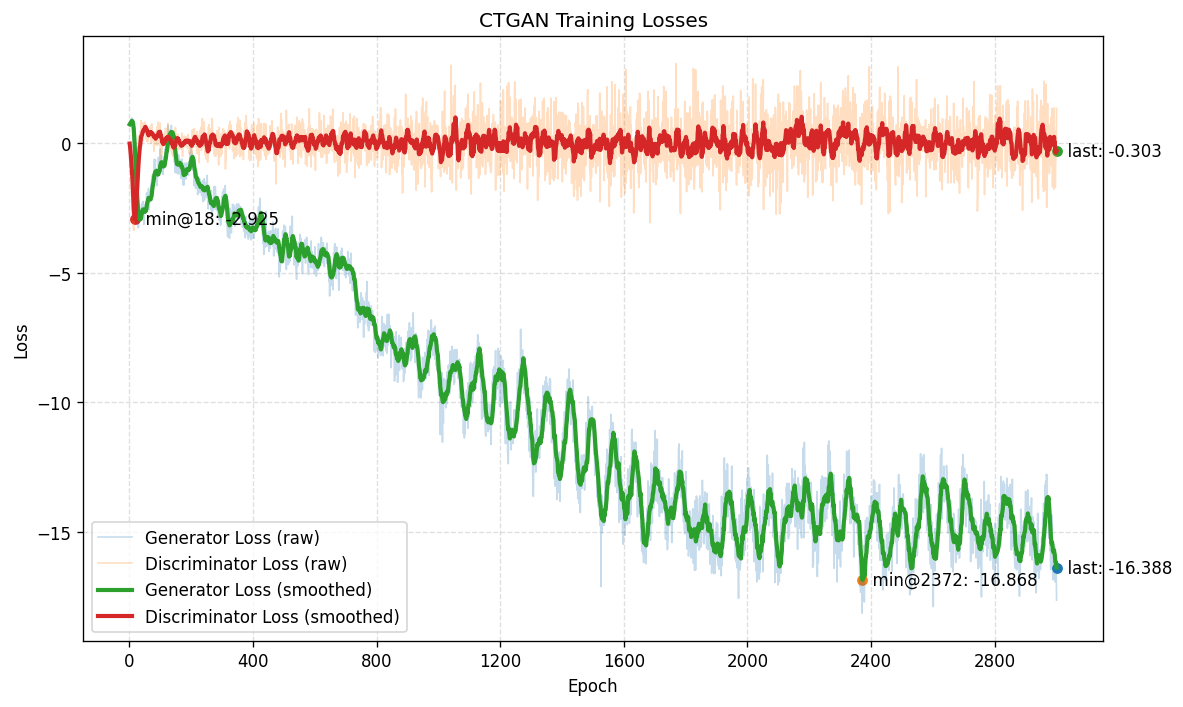

In [28]:
plot_ctgan_losses(loss_df, save_path="../models/training_schedules/ctgan_Mushroom_losses.png")

In [29]:
ctgan.save('./models/ctgan_Mushroom_model.pkl')